# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__13 марта 01:00__</span>.

Мягкий дедлайн: <span style="color:red">__27 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import os
import pathlib
import random

import cv2
from PIL import Image
from typing import Tuple, Union, List, Callable, Optional

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import cv2 as cv

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms: Optional[List[Callable]] = None, image_ext: str = 'jpg', target_ext: str = 'png'):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = pathlib.Path(images_dir) if isinstance(images_dir, str) else images_dir
        self.target_dir = pathlib.Path(target_dir) if isinstance(target_dir, str) else target_dir
        self.transforms = transforms
        
        self.image_ext = image_ext
        self.target_ext = target_ext
        
        self.objects_names = self._lookup_dirs()
        
    def _lookup_dirs(self) -> List[str]:
        object_names = [p.stem for p in self.images_dir.glob(f'*.{self.image_ext}')]
        
        return object_names
        
    def __len__(self):
        return len(self.objects_names)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        objects_name = self.objects_names[idx]
        img_path = self.images_dir.joinpath(f"{objects_name}.{self.image_ext}")
        mask_path = self.target_dir.joinpath(f"{objects_name}.{self.target_ext}")
        
        # print(f"{img_path=}\t{mask_path=}")
        
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('1')
        
        if self.transforms is not None:
            for transform in self.transforms:
                img, mask = transform(img, mask)
        
        return img, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

In [3]:
from torchvision import transforms

In [4]:
class RandomFlip(object):
    def __init__(self, p: float):
        if not isinstance(p, float):
            raise TypeError(f'p must be float, not {type(p)=}')
        if not (0.0 <= p <= 1.0):
            raise ValueError(f'p must be in [0.0, 1.0], {p=:.4f}')
        
        self.p = p
    
    def __call__(self, img, target):
        rs = (np.random.rand(1) < self.p)[0]
        
        if rs:
            return transforms.functional.hflip(img), transforms.functional.hflip(target)
        return img, target

class RandomCrop(object):
    def __init__(self, p: float, size: tuple[float, float]):      
        self.p = p
        self.size = size
    
    def __call__(self, img, target):
        rs = (np.random.rand(1) < self.p)[0]
        
        if not rs:
            return img, target
        
        top = np.random.randint(img.shape[2] - self.size[1])
        left = np.random.randint(img.shape[1] - self.size[0])
        
        height = self.size[1]
        width = self.size[0]
        
        return (
            transforms.functional.resized_crop(
                img,
                top, left, height, width,
                size=img.size()[1:],
            ), 
            transforms.functional.resized_crop(
                target,
                top, left, height, width,
                size=target.size()[1:],
            ), 
        )

class ColorJitter(transforms.ColorJitter):
    def __init__(self, *args, **kwargs):
        super(ColorJitter).__init__(*args, **kwargs)
    
    def __call__(self, img, target):
        return super(ColorJitter).__call__(img), target

class RandomBackground(object):
    def __init__(self, p: float, backgrounds: List[torch.Tensor]):
        self.p = p
        self.backgrounds = backgrounds
        
    def __call__(self, img, target):
        rs = (np.random.rand(1) < self.p)[0]
        if not rs:
            return img, target
        
        back_idx = np.random.choice(len(self.backgrounds))
        back = self.backgrounds[back_idx]
        
        img[:, target.squeeze() == 0] = back[:, target.squeeze() == 0]
        
        return img, target

class Normalize(transforms.Normalize):
    def __init__(self, *args, **kwargs):
        super(Normalize, self).__init__(*args, **kwargs)
    
    def __call__(self, img, target):
        return super(Normalize, self).__call__(img), target

class ToTensor(transforms.ToTensor):
    def __init__(self, *args, **kwargs):
        super(ToTensor, self).__init__(*args, **kwargs)
        
    def __call__(self, img, target):
        return super(ToTensor, self).__call__(img), super(ToTensor, self).__call__(target)

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

Атмосферные фоны для изображений взяты [отсюда](https://vk.com/gum_2)

In [5]:
def prepare_backgrounds(sz: Tuple[int, int]):
    paths = pathlib.Path("backgrounds")
    
    for path in paths.glob("*.jp*"):
        back = Image.open(path)
        back = transforms.Resize(size=sz)(back)
        yield transforms.ToTensor()(back)

In [6]:
DATA_PATH = pathlib.Path(os.getcwd(), 'people_data')

train_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('train'),
    target_dir=DATA_PATH.joinpath('train_mask'),
    transforms=[
        ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('test'),
    target_dir=DATA_PATH.joinpath('test_mask'),
    transforms=[
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

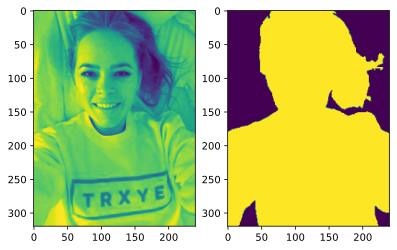

In [7]:
_, ax = plt.subplots(ncols=2)

ax[0].imshow(train_dataset[0][0].numpy()[0, :, :])
ax[1].imshow(train_dataset[0][1].numpy()[0, :, :])

Функция для отображения изображения:

In [8]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

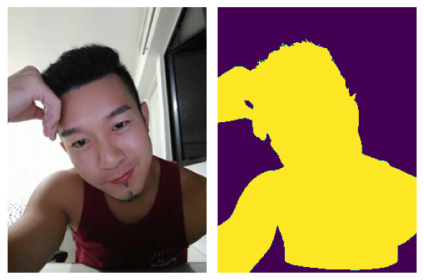

In [9]:
show_idx_image(train_dataset, 159)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [10]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=3)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=3, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [11]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = 1 - 2 * torch.sum(true_labels * logits, dim=[-2, -1]) / torch.sum(true_labels + logits + self.eps, dim=[-2, -1])
        
        # print(f"Dice: {logits.shape=}\t{loss_value.shape=}")
        
        if self.reduction == 'mean':
            loss_value = torch.mean(loss_value)
        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value)
        
        return loss_value

Проверка реализации:

In [12]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

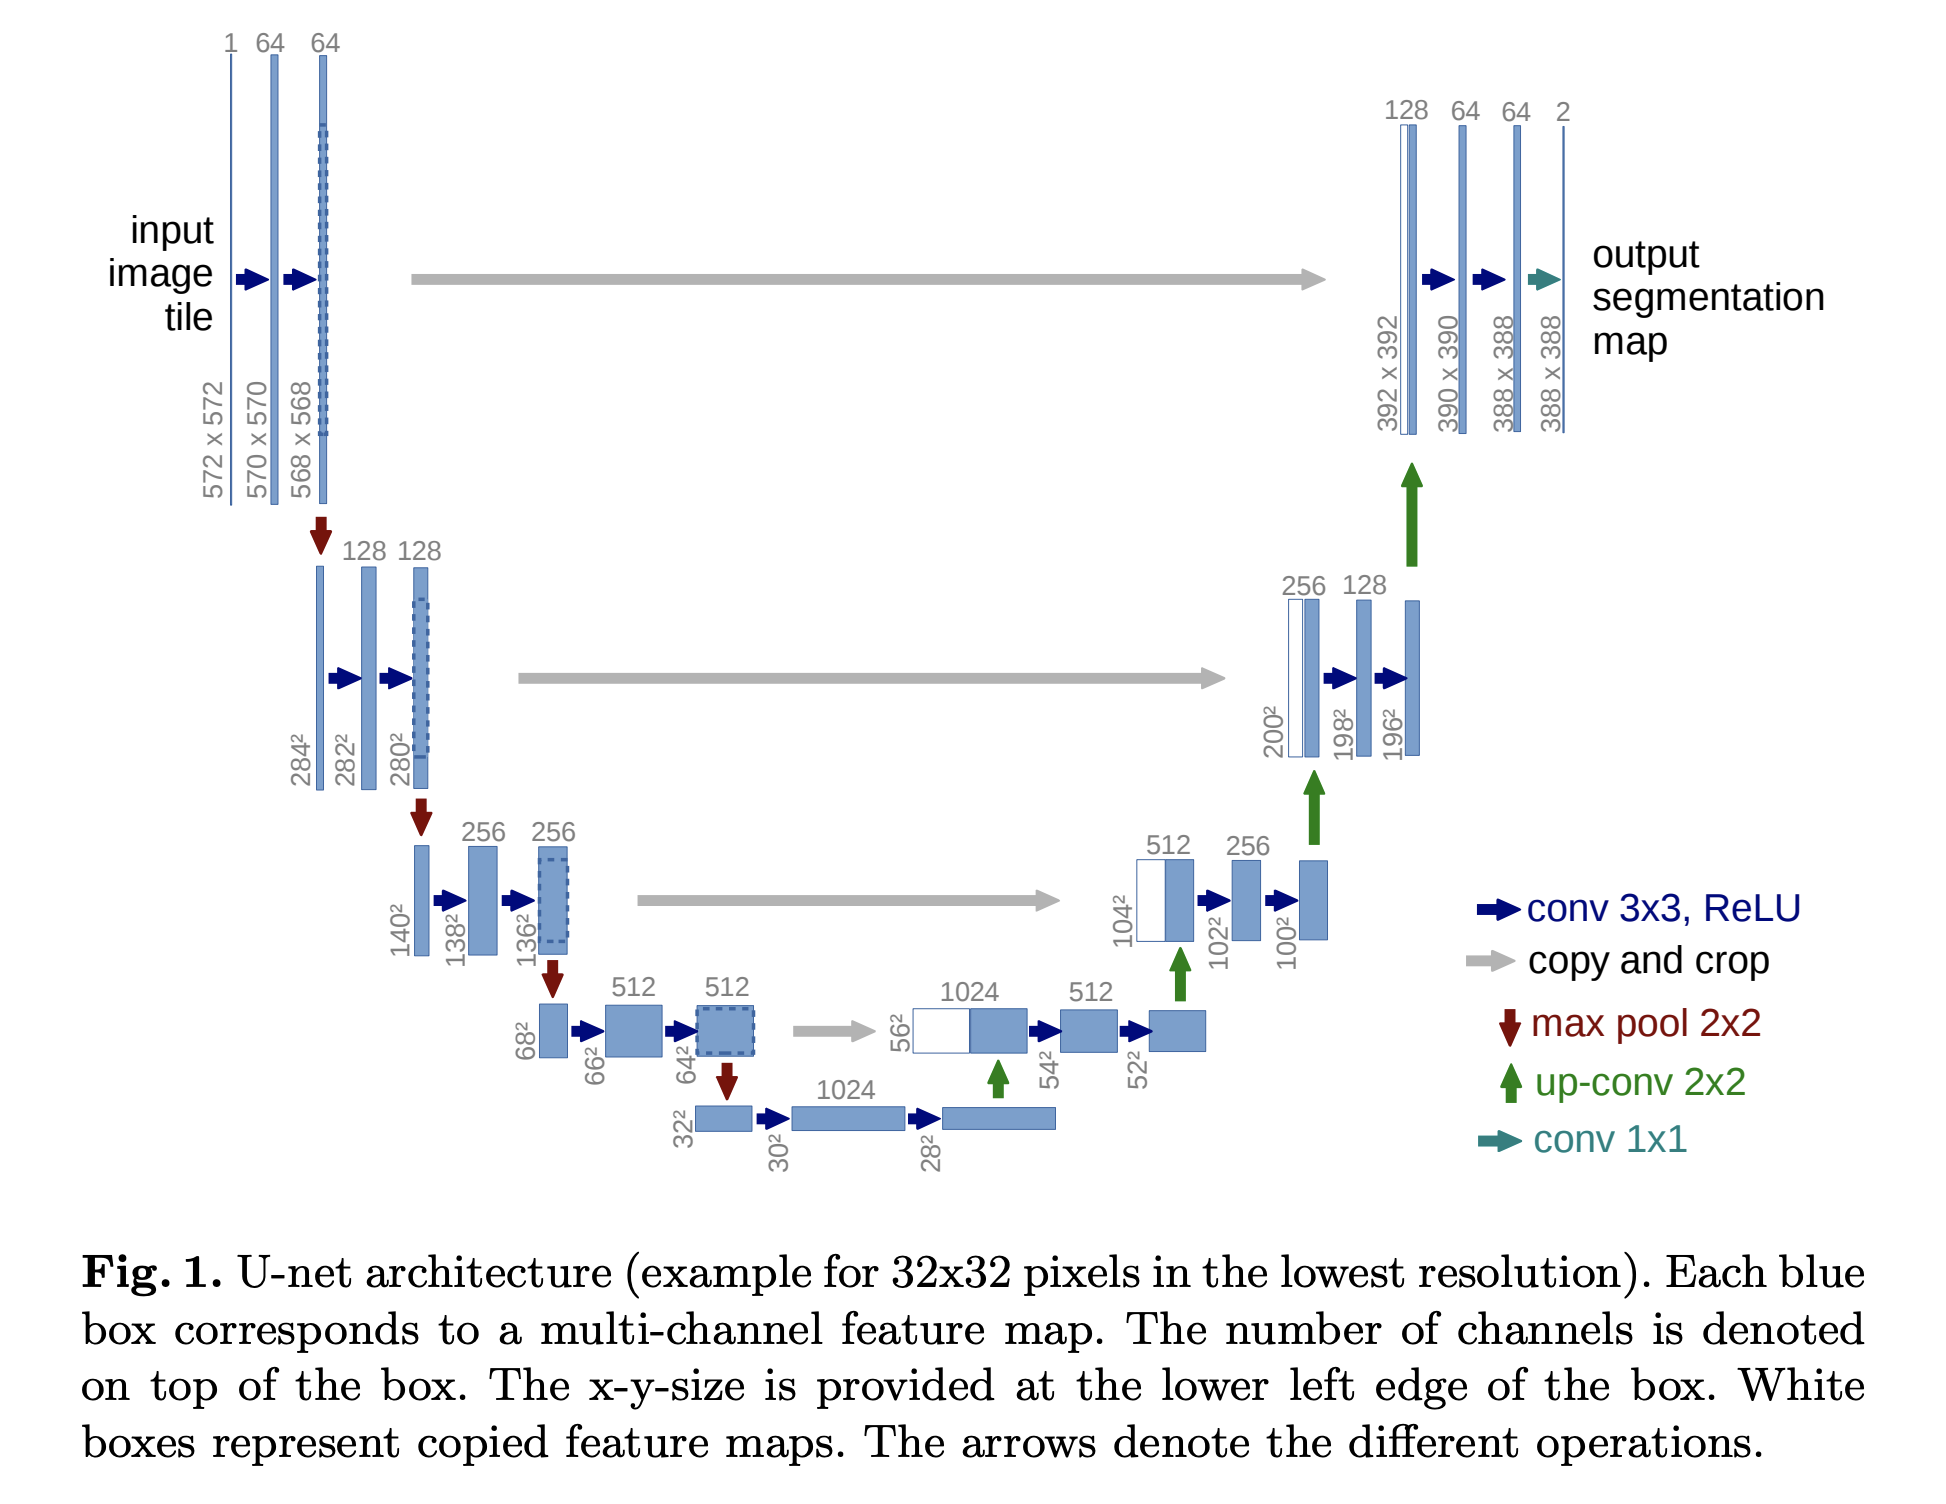

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [13]:
feature_extractor = vgg13(weights=VGG13_Weights.DEFAULT).features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=True)
  (17): Conv2d(512, 512, kernel_si

In [14]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        blocks_gen = VGG13Encoder.__blocks_extractor(vgg13(weights=weights).features)
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList([block for _, block in zip(range(num_blocks), blocks_gen)])

    @staticmethod
    def __blocks_extractor(fe):
        fe = iter(fe)
        while True:
            block = nn.Sequential(*(b for _, b in zip(range(4), fe)))
            yield block
            next(fe) # drop MaxPool2d
            

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
            
        return activations

In [15]:
VGG13Encoder(num_blocks=3)

VGG13Encoder(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
)

In [16]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

print("\n".join(f"{idx=}\tactivation={torch.linalg.norm(act).item():.4f}" for idx, act in enumerate(out)))

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

idx=0	activation=902.2188
idx=1	activation=571.0300
idx=2	activation=648.0689


#### `Decoder`

In [17]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=out_channels * 2, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.ReLU(),
        )
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # print(f"{down.shape=}\t{left.shape=}",end="\t")
        
        x = self.upconv(F.interpolate(down, scale_factor=2))
        # print(f"{x.shape=}")
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat([x, left], dim=1)
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv_block(x)

        return x

In [18]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [19]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        
        # your code here
        self.decoder = Decoder(num_blocks=num_blocks-1, num_filters=64)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)

        return x

In [20]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [21]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None, with_logits: bool = False):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        self.with_logits = with_logits
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        if self.with_logits:
            logits = F.sigmoid(logits)
        
        logits = torch.where(logits > self.threshold, 1.0, 0.0)
        
        prod_sum = torch.sum(logits * true_labels, dim=[-2, -1])
        score = prod_sum / (torch.sum(true_labels, dim=[-2, -1]) + torch.sum(logits, dim=[-2, -1]) - prod_sum)
        
        # print(f"IoU: {logits.shape=}\t{score.shape=}")
        
        if self.reduction == 'sum':
            score = torch.sum(score)
        elif self.reduction == 'mean':
            score = torch.mean(score)
            
        return score

In [22]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

## Цикл обучения и логирование

In [24]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

device

device(type='cuda', index=0)

In [25]:
from itertools import count

In [26]:
def train_epoch(
    network,
    train_loader,
    criterion,
    metric,
    optimizer,
    writer: SummaryWriter,
    logging_interval: int = 1,
    logger_step_cntr: count = None,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    logger_step_cntr = count() if logger_step_cntr is None else logger_step_cntr
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits.squeeze(), masks.squeeze())
        loss.backward()
        optimizer.step()
        logger_step = next(logger_step_cntr)
        
        if logger_step % logging_interval == 0:
            mt = metric(logits.squeeze(), masks.squeeze()).item()
            ls = loss.item()
            
            gn = torch.Tensor([0.0]).to(device)
            wn = torch.Tensor([0.0]).to(device)
            
            with torch.no_grad():
                for param in model.parameters():
                    gn += torch.norm(param.grad) ** 2 if param.grad is not None else 0.0
                    wn += torch.norm(param.data) ** 2
            
            gn = gn.item() ** 0.5
            wn = wn.item() ** 0.5
                
            
            writer.add_scalar('Loss/train', ls, logger_step // logging_interval)
            writer.add_scalar('IoU/train', mt, logger_step // logging_interval)
            writer.add_scalar('Stats/WeightsNorm', wn, logger_step // logging_interval)
            writer.add_scalar('Stats/GradNorm', gn, logger_step // logging_interval)
            
            print(
                f'\tTest set at batch {logger_step:6}: '
                f'Avg. loss: {ls:.4f}',
                f'IoU: {mt}',
                f'GradNorm: {gn:.8f}',
            )

In [27]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    metric,
    writer: SummaryWriter,
    epoch_no: int
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    val_metric = 0

    network.eval()  # switch network submodules to test mode
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        logits = network(images)
        
        # print(f"Val_epoch: {logits.shape=}\t{masks.shape=}")
        
        # print(f"crt: {criterion(logits, masks).item():.8f}")
        val_loss += criterion(logits.squeeze(), masks.squeeze()).item()        
        val_metric += metric(logits.squeeze(), masks.squeeze()).item()

    val_loss = val_loss / len(val_loader.dataset)
    val_metric = val_metric / len(val_loader.dataset)

    writer.add_scalar('Loss/val', val_loss, epoch_no)
    writer.add_scalar('IoU/val', val_metric, epoch_no)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'IoU: {val_metric}',
    )
    
    return val_loss, val_metric

In [28]:
@torch.no_grad()
def prepare_figures(images, masks, logits):
    images = images.cpu()
    masks = masks.cpu().numpy()
    logits = logits.cpu().numpy()
    
    for i in range(images.shape[0]):
        fig, ax = plt.subplots(ncols=2, nrows=2)
        
        ax[0, 0].imshow(np.maximum(
            np.minimum(images[i].permute(1, 2, 0).numpy(), 1.0),
            0.0
        ))
        ax[0, 1].imshow(masks[i, 0, :, :], cmap='gray')
        
        ax[1, 0].imshow(logits[i, 0, :, :], cmap='gray')
        ax[1, 1].imshow(logits[i, 0, :, :] > 0.0, cmap='gray')
        
        yield fig

@torch.no_grad()
def log_images(
        network,
        samples_loader,
        writer: SummaryWriter,
        epoch: int,
):
    cntr = count(0)
    for images, masks in samples_loader:
        logits = network(images.to(device)).cpu()
        for fig, idx in zip(prepare_figures(images, masks, logits), cntr):
            writer.add_figure(
                f'images/{idx}',
                fig,
                epoch
            )

In [29]:
def train_val(
    network,
    n_epochs,
    train_criterion,
    train_metric,
    val_criterion,
    val_metric,
    optimizer,
    lr_scheduler,
    train_loader,
    val_loader,
    samples_loader,
    writer: SummaryWriter,
    logging_interval: int = 5,
    best_dump_path: str = None,
    metric_dump_threshold: float = 0.0,
):
    """full cycle of neural network training"""

    logger_step_cntr = count(0)
    current_val_loss, current_val_metric = val_epoch(network, val_loader, val_criterion, val_metric, writer, epoch_no=0)
    
    best_val_loss = current_val_loss
    best_val_metric = current_val_metric
    
    for epoch in range(1, n_epochs + 1):
        writer.add_scalar('Params/LR', optimizer.state_dict()['param_groups'][0]['lr'], epoch)
        train_epoch(network, train_loader, train_criterion, train_metric, optimizer, writer, logging_interval, logger_step_cntr)
        current_val_loss, current_val_metric = val_epoch(network, val_loader, val_criterion, val_metric, writer, epoch_no=epoch)
        lr_scheduler.step(current_val_loss)
        
        log_images(
            model, samples_loader, writer, epoch
        )
        
        for name, param in model.named_parameters():
            writer.add_histogram(f'Layers/{name}', param, global_step=epoch)
        
        writer.flush()
        
        if (current_val_metric > best_val_metric) and (best_dump_path is not None) and (current_val_metric > metric_dump_threshold):
            best_val_metric = current_val_metric
            with open(best_dump_path, "wb") as f:
                torch.save(
                    obj=(model.state_dict(), optimizer.state_dict(), current_val_loss, current_val_metric),
                    f=f
                )

In [30]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """
    

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
#     torch.use_deterministic_algorithms(True) # если нужно гарантировать 1000% воспроизводимость

    # Для Dataloader
    g = torch.Generator()
    g.manual_seed(seed)
    
    return g

# Для каждого woerker в Daaloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [40]:
def init_loaders(g, train_transforms = None, test_transforms = None, num_workers: int = 0):
    DATA_PATH = pathlib.Path(os.getcwd(), 'people_data')

    train_transforms = [ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] if train_transforms is None else train_transforms
    test_transforms = [ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] if test_transforms is None else test_transforms

    train_dataset = PhotosDataset(
        images_dir=DATA_PATH.joinpath('train'),
        target_dir=DATA_PATH.joinpath('train_mask'),
        transforms=train_transforms
    )

    test_dataset = PhotosDataset(
        images_dir=DATA_PATH.joinpath('test'),
        target_dir=DATA_PATH.joinpath('test_mask'),
        transforms=test_transforms
    )

    test_data_loader = DataLoader(test_dataset, batch_size=32, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
    train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=num_workers, shuffle=True, worker_init_fn=seed_worker, generator=g)
    
    samples_data_loader = DataLoader(
        torch.utils.data.Subset(train_dataset, indices=[0, 1]) + torch.utils.data.Subset(test_dataset, indices=[0, 1]),
        drop_last=False,
        batch_size=8,
        shuffle=False
    )
    
    return train_data_loader, test_data_loader, samples_data_loader

In [41]:
class MixedLoss(torch.nn.Module):
    def __init__(self, crt_1, crt_2, gamma):
        """
        :param crt_1: loss function 1
        :param crt_2: loss function 2
        :param gamma: barycentric coordinate
        """
        super(MixedLoss, self).__init__()
        
        self.crt_1 = crt_1
        self.crt_2 = crt_2
        self.gamma = gamma
        
    def __call__(self, *args, **kwargs):
        return self.gamma * self.crt_1(*args, **kwargs) + (1.0 - self.gamma) * self.crt_2(*args, **kwargs)

## Обучение UNet

### Отладочный запуск

In [ ]:
torch.cuda.empty_cache()

params = {
    'model_name': 'DEB_2',
    'num_blocks': 3,
    'num_classes': 1,
    'lr':1e-3,
    'gamma': 0.1,
    'loss_function': 'Mixed: Dice and BCE',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 5,
    'seed': 42, 
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = MixedLoss(
    crt_1=nn.BCEWithLogitsLoss(reduction='mean'),
    crt_2=DiceLoss(reduction='mean'),
    gamma=params['gamma']
).to(device)

val_loss = MixedLoss(
    crt_1=nn.BCEWithLogitsLoss(reduction='sum'),
    crt_2=DiceLoss(reduction='sum'),
    gamma=params['gamma']
).to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

### Подбор lr для BCE loss

In [64]:
for idx, lr in enumerate(np.logspace(-5, -3, num=5, base=10)):
    torch.cuda.empty_cache()

    params = {
        'model_name': f'{idx+1}',
        'num_blocks': 4,
        'num_classes': 1,
        'lr':lr,
        'gamma': 0.0,
        'loss_function': 'BCE',
        'scheduler': 'ReduceLROnPlateau',
        'n_epochs': 10,
        'seed': 42
    }

    g = set_global_seed(params['seed'])

    writer = SummaryWriter(f'Unet_CE/LR_seacrh/{params["model_name"]}')

    train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

    model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

    writer.add_hparams(
        params,
        {}
    )

    writer.add_graph(
        model=model,
        verbose=False,
        input_to_model=next(iter(train_data_loader))[0].to(device)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

    train_loss = nn.BCEWithLogitsLoss(reduction='mean').to(device)
    val_loss = nn.BCEWithLogitsLoss(reduction='sum').to(device)

    IoU_train = IoUScore(0.0, reduction='mean').to(device)
    IoU_val = IoUScore(0.0, reduction='sum').to(device)

    train_val(
        network=model,
        train_criterion=train_loss,
        train_metric=IoU_train,
        val_criterion=val_loss,
        val_metric=IoU_val,
        optimizer=optimizer,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        samples_loader=samples_data_loader,
        n_epochs=params['n_epochs'],
        writer=writer,
        lr_scheduler=lr_scheduler,
        logging_interval=10,
        best_dump_path=f'./Unet_CE/LR_seacrh/{params["model_name"]}/{params["model_name"]}_best.bin',
        metric_dump_threshold=0.8,
    )

Test set: Avg. loss: 53865.2172 IoU: 0.3260701903214691
	Test set at batch      0: Avg. loss: 0.6999 IoU: 0.2691842317581177 GradNorm: 0.58297512
	Test set at batch     10: Avg. loss: 0.6880 IoU: 0.4396915137767792 GradNorm: 0.52326205
	Test set at batch     20: Avg. loss: 0.6631 IoU: 0.5880096554756165 GradNorm: 0.75202038
	Test set at batch     30: Avg. loss: 0.6513 IoU: 0.5542433261871338 GradNorm: 0.46241776
	Test set at batch     40: Avg. loss: 0.5322 IoU: 0.6327159404754639 GradNorm: 0.94021119
	Test set at batch     50: Avg. loss: 0.4605 IoU: 0.6818583607673645 GradNorm: 0.92770826
	Test set at batch     60: Avg. loss: 0.4726 IoU: 0.7350943088531494 GradNorm: 0.75055666
	Test set at batch     70: Avg. loss: 0.3586 IoU: 0.8553823232650757 GradNorm: 0.70275038
	Test set at batch     80: Avg. loss: 0.4075 IoU: 0.7030289173126221 GradNorm: 1.12400233
	Test set at batch     90: Avg. loss: 0.2934 IoU: 0.7655423283576965 GradNorm: 1.03106318
	Test set at batch    100: Avg. loss: 0.2990

Оптимальное значение lr: 

In [32]:
for idx, lr in enumerate(np.logspace(-7, -3, num=9, base=10)):
    torch.cuda.empty_cache()

    print(f"Model no: {idx+1}\tlr: e{np.log10(lr):.2f}")

    params = {
        'model_name': f'{idx+1}',
        'num_blocks': 4,
        'num_classes': 1,
        'lr': lr,
        'gamma': 0.0,
        'loss_function': 'Dice',
        'scheduler': 'ReduceLROnPlateau',
        'n_epochs': 10,
        'seed': 42
    }

    g = set_global_seed(params['seed'])

    writer = SummaryWriter(f"./Unet_Dice/LR_seacrh/{params['model_name']}")

    train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

    model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

    writer.add_hparams(
        params,
        {}
    )

    writer.add_graph(
        model=model,
        verbose=False,
        input_to_model=next(iter(train_data_loader))[0].to(device)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

    train_loss = DiceLoss(reduction='mean').to(device)
    val_loss = DiceLoss(reduction='sum').to(device)

    IoU_train = IoUScore(0.0, reduction='mean').to(device)
    IoU_val = IoUScore(0.0, reduction='sum').to(device)

    train_val(
        network=model,
        train_criterion=train_loss,
        train_metric=IoU_train,
        val_criterion=val_loss,
        val_metric=IoU_val,
        optimizer=optimizer,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        samples_loader=samples_data_loader,
        n_epochs=params['n_epochs'],
        writer=writer,
        lr_scheduler=lr_scheduler,
        logging_interval=10,
        best_dump_path=f'./Unet_Dice/LR_seacrh/{params["model_name"]}/{params["model_name"]}_best.bin',
        metric_dump_threshold=0.8,
    )

Model no: 1	lr: e-7.00
Test set: Avg. loss: 0.4701 IoU: 0.3260701903214691
	Test set at batch      0: Avg. loss: 0.5011 IoU: 0.2691842317581177 GradNorm: 0.64085638
	Test set at batch     10: Avg. loss: 0.5538 IoU: 0.2801349461078644 GradNorm: 0.55179640
	Test set at batch     20: Avg. loss: 0.4725 IoU: 0.37163621187210083 GradNorm: 0.67900760
	Test set at batch     30: Avg. loss: 0.4856 IoU: 0.3072061538696289 GradNorm: 0.67885490
	Test set at batch     40: Avg. loss: 0.4485 IoU: 0.39051249623298645 GradNorm: 0.63482893
	Test set at batch     50: Avg. loss: 0.4695 IoU: 0.3528134822845459 GradNorm: 0.77048724
	Test set at batch     60: Avg. loss: 0.4801 IoU: 0.2860998511314392 GradNorm: 0.71995162
	Test set at batch     70: Avg. loss: 0.4467 IoU: 0.35874485969543457 GradNorm: 0.75749078
	Test set at batch     80: Avg. loss: 0.4379 IoU: 0.39964914321899414 GradNorm: 0.69750558
	Test set at batch     90: Avg. loss: 0.5464 IoU: 0.2684251666069031 GradNorm: 0.59843949
	Test set at batch   

	Test set at batch    880: Avg. loss: 0.4484 IoU: 0.5614449977874756 GradNorm: 0.69325524
	Test set at batch    890: Avg. loss: 0.4185 IoU: 0.6171653866767883 GradNorm: 0.74241053
	Test set at batch    900: Avg. loss: 0.4445 IoU: 0.5417658686637878 GradNorm: 0.69673617
	Test set at batch    910: Avg. loss: 0.4500 IoU: 0.556466817855835 GradNorm: 0.66551292
	Test set at batch    920: Avg. loss: 0.4726 IoU: 0.5221161842346191 GradNorm: 0.59165270
	Test set at batch    930: Avg. loss: 0.4606 IoU: 0.5502009391784668 GradNorm: 0.63649943
	Test set at batch    940: Avg. loss: 0.4659 IoU: 0.5700305104255676 GradNorm: 0.78073382
	Test set at batch    950: Avg. loss: 0.4833 IoU: 0.5150336027145386 GradNorm: 0.61310463
	Test set at batch    960: Avg. loss: 0.4301 IoU: 0.6039918661117554 GradNorm: 0.74792595
	Test set at batch    970: Avg. loss: 0.4349 IoU: 0.585320234298706 GradNorm: 0.70325261
	Test set at batch    980: Avg. loss: 0.4332 IoU: 0.6099427938461304 GradNorm: 0.65197593
	Test set at

	Test set at batch     70: Avg. loss: 0.4438 IoU: 0.416136234998703 GradNorm: 0.74947382
	Test set at batch     80: Avg. loss: 0.4347 IoU: 0.4462205171585083 GradNorm: 0.69095897
	Test set at batch     90: Avg. loss: 0.5433 IoU: 0.32825762033462524 GradNorm: 0.59176658
	Test set at batch    100: Avg. loss: 0.4086 IoU: 0.4247773289680481 GradNorm: 1.03724287
	Test set at batch    110: Avg. loss: 0.5445 IoU: 0.3795327842235565 GradNorm: 0.52308050
	Test set at batch    120: Avg. loss: 0.4476 IoU: 0.40596896409988403 GradNorm: 0.95676110
	Test set at batch    130: Avg. loss: 0.4561 IoU: 0.4837903082370758 GradNorm: 0.66662795
	Test set at batch    140: Avg. loss: 0.4684 IoU: 0.38989633321762085 GradNorm: 0.73705832
	Test set at batch    150: Avg. loss: 0.4362 IoU: 0.46124371886253357 GradNorm: 0.76900096
	Test set at batch    160: Avg. loss: 0.4286 IoU: 0.5036423206329346 GradNorm: 0.66955527
Test set: Avg. loss: 0.4601 IoU: 0.481859545335702
	Test set at batch    170: Avg. loss: 0.5195 I

	Test set at batch    960: Avg. loss: 0.2169 IoU: 0.6354996562004089 GradNorm: 0.14758621
	Test set at batch    970: Avg. loss: 0.2300 IoU: 0.6256111860275269 GradNorm: 0.27031651
	Test set at batch    980: Avg. loss: 0.2218 IoU: 0.6291080713272095 GradNorm: 0.21792381
	Test set at batch    990: Avg. loss: 0.1827 IoU: 0.7018333673477173 GradNorm: 0.42116632
	Test set at batch   1000: Avg. loss: 0.2548 IoU: 0.6015608310699463 GradNorm: 0.22721784
	Test set at batch   1010: Avg. loss: 0.2245 IoU: 0.6399544477462769 GradNorm: 0.19290844
Test set: Avg. loss: 0.2495 IoU: 0.6040038927227047
	Test set at batch   1020: Avg. loss: 0.2214 IoU: 0.6333838105201721 GradNorm: 0.25088676
	Test set at batch   1030: Avg. loss: 0.2204 IoU: 0.6355240345001221 GradNorm: 0.24563534
	Test set at batch   1040: Avg. loss: 0.2711 IoU: 0.5721029043197632 GradNorm: 0.10584398
	Test set at batch   1050: Avg. loss: 0.2314 IoU: 0.6388379335403442 GradNorm: 0.19270301
	Test set at batch   1060: Avg. loss: 0.2128 IoU

	Test set at batch    150: Avg. loss: 0.3961 IoU: 0.6355822086334229 GradNorm: 0.92901318
	Test set at batch    160: Avg. loss: 0.3872 IoU: 0.6952028274536133 GradNorm: 0.86711983
Test set: Avg. loss: 0.4097 IoU: 0.6024961945012952
	Test set at batch    170: Avg. loss: 0.4710 IoU: 0.48031750321388245 GradNorm: 0.89983243
	Test set at batch    180: Avg. loss: 0.4578 IoU: 0.4925346374511719 GradNorm: 0.88095749
	Test set at batch    190: Avg. loss: 0.3869 IoU: 0.6003447771072388 GradNorm: 1.15211919
	Test set at batch    200: Avg. loss: 0.3691 IoU: 0.5817668437957764 GradNorm: 1.30729132
	Test set at batch    210: Avg. loss: 0.4225 IoU: 0.5036171674728394 GradNorm: 1.19615288
	Test set at batch    220: Avg. loss: 0.2535 IoU: 0.7202481031417847 GradNorm: 1.58755621
	Test set at batch    230: Avg. loss: 0.3200 IoU: 0.6006782650947571 GradNorm: 1.21823114
	Test set at batch    240: Avg. loss: 0.2172 IoU: 0.666126549243927 GradNorm: 0.98419312
	Test set at batch    250: Avg. loss: 0.2438 IoU

	Test set at batch   1030: Avg. loss: 0.1052 IoU: 0.8256512880325317 GradNorm: 0.76739873
	Test set at batch   1040: Avg. loss: 0.1258 IoU: 0.791576087474823 GradNorm: 0.49323854
	Test set at batch   1050: Avg. loss: 0.1436 IoU: 0.7776287794113159 GradNorm: 0.54045332
	Test set at batch   1060: Avg. loss: 0.1039 IoU: 0.8253734111785889 GradNorm: 0.98870581
	Test set at batch   1070: Avg. loss: 0.1298 IoU: 0.7785990238189697 GradNorm: 0.42734004
	Test set at batch   1080: Avg. loss: 0.0848 IoU: 0.8561817407608032 GradNorm: 0.53014686
	Test set at batch   1090: Avg. loss: 0.0902 IoU: 0.844616174697876 GradNorm: 0.69782756
	Test set at batch   1100: Avg. loss: 0.1260 IoU: 0.7905085682868958 GradNorm: 0.58442370
	Test set at batch   1110: Avg. loss: 0.0986 IoU: 0.8316289186477661 GradNorm: 0.68915551
	Test set at batch   1120: Avg. loss: 0.1238 IoU: 0.7883638143539429 GradNorm: 0.53564890
	Test set at batch   1130: Avg. loss: 0.0888 IoU: 0.8481959700584412 GradNorm: 0.44513187
	Test set at

	Test set at batch    220: Avg. loss: 0.1591 IoU: 0.7203797101974487 GradNorm: 0.18934411
	Test set at batch    230: Avg. loss: 0.2489 IoU: 0.601934552192688 GradNorm: 0.19038206
	Test set at batch    240: Avg. loss: 0.1664 IoU: 0.6707773804664612 GradNorm: 0.21122189
	Test set at batch    250: Avg. loss: 0.1826 IoU: 0.6529529690742493 GradNorm: 0.20563163
	Test set at batch    260: Avg. loss: 0.2216 IoU: 0.6489999294281006 GradNorm: 0.26364150
	Test set at batch    270: Avg. loss: 0.2608 IoU: 0.6543559432029724 GradNorm: 0.30244151
	Test set at batch    280: Avg. loss: 0.1836 IoU: 0.8128314018249512 GradNorm: 0.44224893
	Test set at batch    290: Avg. loss: 0.2010 IoU: 0.7533060312271118 GradNorm: 0.43100936
	Test set at batch    300: Avg. loss: 0.1420 IoU: 0.8035478591918945 GradNorm: 0.67928478
	Test set at batch    310: Avg. loss: 0.1368 IoU: 0.7958444952964783 GradNorm: 0.56937428
	Test set at batch    320: Avg. loss: 0.0869 IoU: 0.8623061776161194 GradNorm: 0.43291482
	Test set a

	Test set at batch   1110: Avg. loss: 0.0793 IoU: 0.8569628000259399 GradNorm: 0.88906540
	Test set at batch   1120: Avg. loss: 0.0743 IoU: 0.8644870519638062 GradNorm: 0.48390541
	Test set at batch   1130: Avg. loss: 0.0734 IoU: 0.8701070547103882 GradNorm: 0.32771264
	Test set at batch   1140: Avg. loss: 0.0764 IoU: 0.8626399636268616 GradNorm: 0.92118528
	Test set at batch   1150: Avg. loss: 0.0642 IoU: 0.8820521831512451 GradNorm: 0.70306254
	Test set at batch   1160: Avg. loss: 0.0980 IoU: 0.8321040272712708 GradNorm: 0.54299839
	Test set at batch   1170: Avg. loss: 0.0643 IoU: 0.8831053376197815 GradNorm: 0.57448188
	Test set at batch   1180: Avg. loss: 0.0782 IoU: 0.8594222068786621 GradNorm: 0.42486519
Test set: Avg. loss: 0.0776 IoU: 0.8612815369950965
	Test set at batch   1190: Avg. loss: 0.0743 IoU: 0.8694082498550415 GradNorm: 0.59657781
	Test set at batch   1200: Avg. loss: 0.0964 IoU: 0.8309373259544373 GradNorm: 0.75391246
	Test set at batch   1210: Avg. loss: 0.0663 IoU

	Test set at batch    300: Avg. loss: 0.0627 IoU: 0.88396155834198 GradNorm: 0.43567050
	Test set at batch    310: Avg. loss: 0.0895 IoU: 0.8426167964935303 GradNorm: 0.46328969
	Test set at batch    320: Avg. loss: 0.0561 IoU: 0.8960444927215576 GradNorm: 0.39759901
	Test set at batch    330: Avg. loss: 0.0736 IoU: 0.865402340888977 GradNorm: 0.45688705
Test set: Avg. loss: 0.0871 IoU: 0.846461072881171
	Test set at batch    340: Avg. loss: 0.1016 IoU: 0.8212482929229736 GradNorm: 0.96088251
	Test set at batch    350: Avg. loss: 0.0719 IoU: 0.8704476356506348 GradNorm: 0.94863249
	Test set at batch    360: Avg. loss: 0.0588 IoU: 0.8954665064811707 GradNorm: 0.55395640
	Test set at batch    370: Avg. loss: 0.0619 IoU: 0.8890292644500732 GradNorm: 0.27063557
	Test set at batch    380: Avg. loss: 0.0944 IoU: 0.8483651876449585 GradNorm: 0.44984202
	Test set at batch    390: Avg. loss: 0.0925 IoU: 0.8423209190368652 GradNorm: 0.39660853
	Test set at batch    400: Avg. loss: 0.0994 IoU: 0.

Test set: Avg. loss: 0.0657 IoU: 0.8809374477846402
	Test set at batch   1190: Avg. loss: 0.0532 IoU: 0.9011147618293762 GradNorm: 0.39987576
	Test set at batch   1200: Avg. loss: 0.0703 IoU: 0.8728566765785217 GradNorm: 0.46544294
	Test set at batch   1210: Avg. loss: 0.0585 IoU: 0.8929426670074463 GradNorm: 0.60185061
	Test set at batch   1220: Avg. loss: 0.1075 IoU: 0.8152559995651245 GradNorm: 1.37397737
	Test set at batch   1230: Avg. loss: 0.0874 IoU: 0.8498383164405823 GradNorm: 0.64614477
	Test set at batch   1240: Avg. loss: 0.0566 IoU: 0.8957942724227905 GradNorm: 0.42972376
	Test set at batch   1250: Avg. loss: 0.0348 IoU: 0.9335465431213379 GradNorm: 0.43444804
	Test set at batch   1260: Avg. loss: 0.0649 IoU: 0.8819018006324768 GradNorm: 0.38707643
	Test set at batch   1270: Avg. loss: 0.0758 IoU: 0.8671854734420776 GradNorm: 0.79293019
	Test set at batch   1280: Avg. loss: 0.0803 IoU: 0.8587523698806763 GradNorm: 0.83983296
	Test set at batch   1290: Avg. loss: 0.0497 IoU

	Test set at batch    370: Avg. loss: 0.0613 IoU: 0.8893352150917053 GradNorm: 0.22184937
	Test set at batch    380: Avg. loss: 0.0791 IoU: 0.8679771423339844 GradNorm: 0.46916069
	Test set at batch    390: Avg. loss: 0.0724 IoU: 0.8732890486717224 GradNorm: 0.44494359
	Test set at batch    400: Avg. loss: 0.0764 IoU: 0.8647840619087219 GradNorm: 0.62609762
	Test set at batch    410: Avg. loss: 0.0478 IoU: 0.9098620414733887 GradNorm: 0.28162994
	Test set at batch    420: Avg. loss: 0.0380 IoU: 0.9287205934524536 GradNorm: 0.34114904
	Test set at batch    430: Avg. loss: 0.0676 IoU: 0.8762572407722473 GradNorm: 0.52706198
	Test set at batch    440: Avg. loss: 0.0556 IoU: 0.8987733125686646 GradNorm: 0.23772485
	Test set at batch    450: Avg. loss: 0.0498 IoU: 0.9079762697219849 GradNorm: 0.36109946
	Test set at batch    460: Avg. loss: 0.0873 IoU: 0.8464020490646362 GradNorm: 0.36445066
	Test set at batch    470: Avg. loss: 0.0495 IoU: 0.9067175388336182 GradNorm: 0.69269461
	Test set 

	Test set at batch   1260: Avg. loss: 0.0410 IoU: 0.922944188117981 GradNorm: 0.34109597
	Test set at batch   1270: Avg. loss: 0.0298 IoU: 0.9433646202087402 GradNorm: 0.30474645
	Test set at batch   1280: Avg. loss: 0.0396 IoU: 0.9268991947174072 GradNorm: 0.53871771
	Test set at batch   1290: Avg. loss: 0.0324 IoU: 0.9384467601776123 GradNorm: 0.48110591
	Test set at batch   1300: Avg. loss: 0.0435 IoU: 0.9184761047363281 GradNorm: 0.45267275
	Test set at batch   1310: Avg. loss: 0.0298 IoU: 0.9438138008117676 GradNorm: 0.46277279
	Test set at batch   1320: Avg. loss: 0.0216 IoU: 0.9584526419639587 GradNorm: 0.25260691
	Test set at batch   1330: Avg. loss: 0.0232 IoU: 0.9549353122711182 GradNorm: 0.35473433
	Test set at batch   1340: Avg. loss: 0.0307 IoU: 0.9407674670219421 GradNorm: 0.45341602
	Test set at batch   1350: Avg. loss: 0.0338 IoU: 0.9370473623275757 GradNorm: 0.18429190
Test set: Avg. loss: 0.0492 IoU: 0.9093717750928081
	Test set at batch   1360: Avg. loss: 0.0222 IoU:

	Test set at batch    450: Avg. loss: 0.0523 IoU: 0.9033442735671997 GradNorm: 0.41109615
	Test set at batch    460: Avg. loss: 0.0789 IoU: 0.8579388856887817 GradNorm: 0.50563722
	Test set at batch    470: Avg. loss: 0.0393 IoU: 0.925061047077179 GradNorm: 0.35918029
	Test set at batch    480: Avg. loss: 0.0345 IoU: 0.9345574975013733 GradNorm: 0.37802858
	Test set at batch    490: Avg. loss: 0.0668 IoU: 0.8786088824272156 GradNorm: 0.46672707
	Test set at batch    500: Avg. loss: 0.0932 IoU: 0.8315958976745605 GradNorm: 0.45145195
Test set: Avg. loss: 0.0589 IoU: 0.89278089915607
	Test set at batch    510: Avg. loss: 0.0894 IoU: 0.8447479009628296 GradNorm: 0.31984727
	Test set at batch    520: Avg. loss: 0.0527 IoU: 0.9012928009033203 GradNorm: 0.45953048
	Test set at batch    530: Avg. loss: 0.0332 IoU: 0.9367026686668396 GradNorm: 0.17915626
	Test set at batch    540: Avg. loss: 0.0289 IoU: 0.9442746639251709 GradNorm: 0.21565772
	Test set at batch    550: Avg. loss: 0.0400 IoU: 0

	Test set at batch   1340: Avg. loss: 0.0211 IoU: 0.9589251279830933 GradNorm: 0.40301850
	Test set at batch   1350: Avg. loss: 0.0254 IoU: 0.9527242183685303 GradNorm: 0.09188408
Test set: Avg. loss: 0.0476 IoU: 0.9124027549797762
	Test set at batch   1360: Avg. loss: 0.0148 IoU: 0.9712835550308228 GradNorm: 0.12536499
	Test set at batch   1370: Avg. loss: 0.0202 IoU: 0.9606029987335205 GradNorm: 0.26153585
	Test set at batch   1380: Avg. loss: 0.0220 IoU: 0.9576456546783447 GradNorm: 0.13765870
	Test set at batch   1390: Avg. loss: 0.0158 IoU: 0.969111442565918 GradNorm: 0.10656078
	Test set at batch   1400: Avg. loss: 0.0154 IoU: 0.9701034426689148 GradNorm: 0.15889754
	Test set at batch   1410: Avg. loss: 0.0099 IoU: 0.9805634021759033 GradNorm: 0.14705687
	Test set at batch   1420: Avg. loss: 0.0145 IoU: 0.9717090129852295 GradNorm: 0.13252378
	Test set at batch   1430: Avg. loss: 0.0119 IoU: 0.9766581058502197 GradNorm: 0.06456876
	Test set at batch   1440: Avg. loss: 0.0191 IoU:

	Test set at batch    520: Avg. loss: 0.3343 IoU: 0.522545576095581 GradNorm: 0.00000000
	Test set at batch    530: Avg. loss: 0.2428 IoU: 0.62067711353302 GradNorm: 0.00000000
	Test set at batch    540: Avg. loss: 0.2566 IoU: 0.6184489130973816 GradNorm: 0.00000000
	Test set at batch    550: Avg. loss: 0.2762 IoU: 0.57309889793396 GradNorm: 0.00000000
	Test set at batch    560: Avg. loss: 0.2420 IoU: 0.6174722909927368 GradNorm: 0.00000000
	Test set at batch    570: Avg. loss: 0.2033 IoU: 0.6677213907241821 GradNorm: 0.00000000
	Test set at batch    580: Avg. loss: 0.2905 IoU: 0.5690478086471558 GradNorm: 0.00000000
	Test set at batch    590: Avg. loss: 0.3796 IoU: 0.48059892654418945 GradNorm: 0.00000000
	Test set at batch    600: Avg. loss: 0.2664 IoU: 0.5921321511268616 GradNorm: 0.00000000
	Test set at batch    610: Avg. loss: 0.3193 IoU: 0.5371370911598206 GradNorm: 0.00000000
	Test set at batch    620: Avg. loss: 0.3464 IoU: 0.4912451207637787 GradNorm: 0.00000000
	Test set at b

	Test set at batch   1410: Avg. loss: 0.2534 IoU: 0.6090885400772095 GradNorm: 0.00000000
	Test set at batch   1420: Avg. loss: 0.1889 IoU: 0.69098961353302 GradNorm: 0.00000000
	Test set at batch   1430: Avg. loss: 0.2428 IoU: 0.6107714772224426 GradNorm: 0.00000000
	Test set at batch   1440: Avg. loss: 0.2641 IoU: 0.6002945899963379 GradNorm: 0.00000000
	Test set at batch   1450: Avg. loss: 0.3501 IoU: 0.502428412437439 GradNorm: 0.00000000
	Test set at batch   1460: Avg. loss: 0.3354 IoU: 0.5241276025772095 GradNorm: 0.00000000
	Test set at batch   1470: Avg. loss: 0.2874 IoU: 0.5621988773345947 GradNorm: 0.00000000
	Test set at batch   1480: Avg. loss: 0.2259 IoU: 0.6392204165458679 GradNorm: 0.00000000
	Test set at batch   1490: Avg. loss: 0.2507 IoU: 0.6060270071029663 GradNorm: 0.00000000
	Test set at batch   1500: Avg. loss: 0.1903 IoU: 0.6875309348106384 GradNorm: 0.00000000
	Test set at batch   1510: Avg. loss: 0.2920 IoU: 0.591173529624939 GradNorm: 0.00000000
	Test set at b

	Test set at batch    600: Avg. loss: 0.2664 IoU: 0.5921321511268616 GradNorm: 0.00000000
	Test set at batch    610: Avg. loss: 0.3193 IoU: 0.5371370911598206 GradNorm: 0.00000000
	Test set at batch    620: Avg. loss: 0.3464 IoU: 0.4912451207637787 GradNorm: 0.00000000
	Test set at batch    630: Avg. loss: 0.2579 IoU: 0.594541072845459 GradNorm: 0.00000000
	Test set at batch    640: Avg. loss: 0.2494 IoU: 0.6114176511764526 GradNorm: 0.00000000
	Test set at batch    650: Avg. loss: 0.3404 IoU: 0.514563798904419 GradNorm: 0.00000000
	Test set at batch    660: Avg. loss: 0.3139 IoU: 0.5527783632278442 GradNorm: 0.00000000
	Test set at batch    670: Avg. loss: 0.2476 IoU: 0.6260839700698853 GradNorm: 0.00000000
Test set: Avg. loss: 0.2601 IoU: 0.6039797600279463
	Test set at batch    680: Avg. loss: 0.2310 IoU: 0.6586295366287231 GradNorm: 0.00000000
	Test set at batch    690: Avg. loss: 0.1794 IoU: 0.7079541087150574 GradNorm: 0.00000000
	Test set at batch    700: Avg. loss: 0.3282 IoU: 

	Test set at batch   1490: Avg. loss: 0.2507 IoU: 0.6060270071029663 GradNorm: 0.00000000
	Test set at batch   1500: Avg. loss: 0.1903 IoU: 0.6875309348106384 GradNorm: 0.00000000
	Test set at batch   1510: Avg. loss: 0.2920 IoU: 0.591173529624939 GradNorm: 0.00000000
	Test set at batch   1520: Avg. loss: 0.2075 IoU: 0.6585373878479004 GradNorm: 0.00000000
Test set: Avg. loss: 0.2601 IoU: 0.6039797600279463
	Test set at batch   1530: Avg. loss: 0.3000 IoU: 0.5495409965515137 GradNorm: 0.00000000
	Test set at batch   1540: Avg. loss: 0.2532 IoU: 0.6075586080551147 GradNorm: 0.00000000
	Test set at batch   1550: Avg. loss: 0.2535 IoU: 0.6092431545257568 GradNorm: 0.00000000
	Test set at batch   1560: Avg. loss: 0.3075 IoU: 0.5544629096984863 GradNorm: 0.00000000
	Test set at batch   1570: Avg. loss: 0.2178 IoU: 0.6475552916526794 GradNorm: 0.00000000
	Test set at batch   1580: Avg. loss: 0.2715 IoU: 0.5757796168327332 GradNorm: 0.00000000
	Test set at batch   1590: Avg. loss: 0.2452 IoU:

Оптимальное значение lr для Dice loss:

### Подбор loss function

In [36]:
torch.cuda.empty_cache()

params = {
    'model_name': 'Unet_CE',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'BCE',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = nn.BCEWithLogitsLoss(reduction='mean').to(device)
val_loss = nn.BCEWithLogitsLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 53865.2172 IoU: 0.3260701903214691
	Test set at batch      0: Avg. loss: 0.6999 IoU: 0.2691842317581177 GradNorm: 0.58297512
	Test set at batch     10: Avg. loss: 0.5037 IoU: 0.6206742525100708 GradNorm: 1.35248151
	Test set at batch     20: Avg. loss: 0.2072 IoU: 0.8841984272003174 GradNorm: 1.81425536
	Test set at batch     30: Avg. loss: 0.3998 IoU: 0.7280956506729126 GradNorm: 3.28625078
	Test set at batch     40: Avg. loss: 0.2761 IoU: 0.8546144962310791 GradNorm: 2.34747121
	Test set at batch     50: Avg. loss: 0.1796 IoU: 0.8989598155021667 GradNorm: 0.86445869
	Test set at batch     60: Avg. loss: 0.2886 IoU: 0.8228581547737122 GradNorm: 1.18881043
	Test set at batch     70: Avg. loss: 0.2147 IoU: 0.8826684951782227 GradNorm: 1.32166740
	Test set at batch     80: Avg. loss: 0.2555 IoU: 0.8460561037063599 GradNorm: 1.67711211
	Test set at batch     90: Avg. loss: 0.2316 IoU: 0.7993230223655701 GradNorm: 1.52189159
	Test set at batch    100: Avg. loss: 0.2206

	Test set at batch    880: Avg. loss: 0.0947 IoU: 0.943240225315094 GradNorm: 1.10346939
	Test set at batch    890: Avg. loss: 0.0535 IoU: 0.9701111912727356 GradNorm: 0.56478202
	Test set at batch    900: Avg. loss: 0.0526 IoU: 0.96799635887146 GradNorm: 0.45591750
	Test set at batch    910: Avg. loss: 0.0428 IoU: 0.9717049598693848 GradNorm: 0.30836242
	Test set at batch    920: Avg. loss: 0.0639 IoU: 0.9508196115493774 GradNorm: 0.64859244
	Test set at batch    930: Avg. loss: 0.0660 IoU: 0.9514870643615723 GradNorm: 0.62976345
	Test set at batch    940: Avg. loss: 0.0448 IoU: 0.9672499895095825 GradNorm: 0.63076404
	Test set at batch    950: Avg. loss: 0.0599 IoU: 0.9496728777885437 GradNorm: 0.99582276
	Test set at batch    960: Avg. loss: 0.0435 IoU: 0.9731939435005188 GradNorm: 0.40057051
	Test set at batch    970: Avg. loss: 0.0832 IoU: 0.9495733976364136 GradNorm: 1.31671868
	Test set at batch    980: Avg. loss: 0.0630 IoU: 0.962660551071167 GradNorm: 0.91100517
	Test set at b

	Test set at batch   1770: Avg. loss: 0.0181 IoU: 0.9862344861030579 GradNorm: 0.09656765
	Test set at batch   1780: Avg. loss: 0.0239 IoU: 0.9833763837814331 GradNorm: 0.18197416
	Test set at batch   1790: Avg. loss: 0.0172 IoU: 0.9903104305267334 GradNorm: 0.11946560
	Test set at batch   1800: Avg. loss: 0.0243 IoU: 0.9823246598243713 GradNorm: 0.14116343
	Test set at batch   1810: Avg. loss: 0.0204 IoU: 0.9836726784706116 GradNorm: 0.10165153
	Test set at batch   1820: Avg. loss: 0.0221 IoU: 0.9817301630973816 GradNorm: 0.24954337
	Test set at batch   1830: Avg. loss: 0.0194 IoU: 0.9863954186439514 GradNorm: 0.09833564
	Test set at batch   1840: Avg. loss: 0.0207 IoU: 0.9878026247024536 GradNorm: 0.13524307
	Test set at batch   1850: Avg. loss: 0.0291 IoU: 0.9856564402580261 GradNorm: 0.19591504
Test set: Avg. loss: 16613.9535 IoU: 0.9179369338015293
	Test set at batch   1860: Avg. loss: 0.0231 IoU: 0.9786460399627686 GradNorm: 0.11482734
	Test set at batch   1870: Avg. loss: 0.0230

	Test set at batch   2650: Avg. loss: 0.0200 IoU: 0.9874310493469238 GradNorm: 0.18614643
	Test set at batch   2660: Avg. loss: 0.0225 IoU: 0.9845625162124634 GradNorm: 0.18974202
	Test set at batch   2670: Avg. loss: 0.0129 IoU: 0.9879698753356934 GradNorm: 0.07140002
	Test set at batch   2680: Avg. loss: 0.0144 IoU: 0.9867516756057739 GradNorm: 0.07300701
	Test set at batch   2690: Avg. loss: 0.0177 IoU: 0.9882520437240601 GradNorm: 0.08586830
	Test set at batch   2700: Avg. loss: 0.0209 IoU: 0.9873760342597961 GradNorm: 0.13745445
Test set: Avg. loss: 23026.2004 IoU: 0.9165711369074828
	Test set at batch   2710: Avg. loss: 0.0169 IoU: 0.9888001084327698 GradNorm: 0.08553273
	Test set at batch   2720: Avg. loss: 0.0187 IoU: 0.9883239269256592 GradNorm: 0.18508543
	Test set at batch   2730: Avg. loss: 0.0185 IoU: 0.9868309497833252 GradNorm: 0.08595707
	Test set at batch   2740: Avg. loss: 0.0183 IoU: 0.9864994883537292 GradNorm: 0.07083534
	Test set at batch   2750: Avg. loss: 0.0174

	Test set at batch   3540: Avg. loss: 0.0150 IoU: 0.989116907119751 GradNorm: 0.09781171
Test set: Avg. loss: 25887.8901 IoU: 0.9156566917473543
	Test set at batch   3550: Avg. loss: 0.0143 IoU: 0.9883280396461487 GradNorm: 0.06003078
	Test set at batch   3560: Avg. loss: 0.0153 IoU: 0.9875266551971436 GradNorm: 0.06370640
	Test set at batch   3570: Avg. loss: 0.0186 IoU: 0.9849535822868347 GradNorm: 0.09949160
	Test set at batch   3580: Avg. loss: 0.0213 IoU: 0.9857169389724731 GradNorm: 0.12843690
	Test set at batch   3590: Avg. loss: 0.0125 IoU: 0.9888027906417847 GradNorm: 0.06960890
	Test set at batch   3600: Avg. loss: 0.0154 IoU: 0.989788830280304 GradNorm: 0.06478771
	Test set at batch   3610: Avg. loss: 0.0174 IoU: 0.9884561896324158 GradNorm: 0.08504430
	Test set at batch   3620: Avg. loss: 0.0152 IoU: 0.9901806116104126 GradNorm: 0.07814940
	Test set at batch   3630: Avg. loss: 0.0193 IoU: 0.9884603023529053 GradNorm: 0.08959990
	Test set at batch   3640: Avg. loss: 0.0158 I

In [35]:
torch.cuda.empty_cache()

params = {
    'model_name': 'Unet_Dice',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'Dice',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = DiceLoss(reduction='mean').to(device)
val_loss = DiceLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 0.4701 IoU: 0.3260701903214691
	Test set at batch      0: Avg. loss: 0.5011 IoU: 0.2691842317581177 GradNorm: 0.64085638
	Test set at batch     10: Avg. loss: 0.3975 IoU: 0.4653189778327942 GradNorm: 0.00650752
	Test set at batch     20: Avg. loss: 0.2693 IoU: 0.5883528590202332 GradNorm: 0.04102393
	Test set at batch     30: Avg. loss: 0.2808 IoU: 0.5541597604751587 GradNorm: 0.18003939
	Test set at batch     40: Avg. loss: 0.1143 IoU: 0.8023773431777954 GradNorm: 0.95160307
	Test set at batch     50: Avg. loss: 0.0933 IoU: 0.8333228826522827 GradNorm: 0.83391773
	Test set at batch     60: Avg. loss: 0.1397 IoU: 0.7728617787361145 GradNorm: 0.47514334
	Test set at batch     70: Avg. loss: 0.1015 IoU: 0.820855438709259 GradNorm: 0.82578880
	Test set at batch     80: Avg. loss: 0.1226 IoU: 0.7880282402038574 GradNorm: 1.07806573
	Test set at batch     90: Avg. loss: 0.1163 IoU: 0.7977925539016724 GradNorm: 0.37106486
	Test set at batch    100: Avg. loss: 0.0590 IoU:

	Test set at batch    880: Avg. loss: 0.0545 IoU: 0.8982508182525635 GradNorm: 0.59062386
	Test set at batch    890: Avg. loss: 0.0341 IoU: 0.935077428817749 GradNorm: 0.32161180
	Test set at batch    900: Avg. loss: 0.0220 IoU: 0.9576032161712646 GradNorm: 0.20991169
	Test set at batch    910: Avg. loss: 0.0200 IoU: 0.9615330696105957 GradNorm: 0.17646176
	Test set at batch    920: Avg. loss: 0.0453 IoU: 0.9182406663894653 GradNorm: 0.48272069
	Test set at batch    930: Avg. loss: 0.0556 IoU: 0.9030355215072632 GradNorm: 0.37047568
	Test set at batch    940: Avg. loss: 0.0166 IoU: 0.9678300619125366 GradNorm: 0.18767397
	Test set at batch    950: Avg. loss: 0.0508 IoU: 0.9065945148468018 GradNorm: 0.57233267
	Test set at batch    960: Avg. loss: 0.0134 IoU: 0.9738134145736694 GradNorm: 0.08165167
	Test set at batch    970: Avg. loss: 0.0377 IoU: 0.9288464784622192 GradNorm: 0.43543428
	Test set at batch    980: Avg. loss: 0.0282 IoU: 0.94601970911026 GradNorm: 0.42174275
	Test set at 

	Test set at batch   1770: Avg. loss: 0.0101 IoU: 0.9800890684127808 GradNorm: 0.08708979
	Test set at batch   1780: Avg. loss: 0.0201 IoU: 0.9609659910202026 GradNorm: 0.22487232
	Test set at batch   1790: Avg. loss: 0.0177 IoU: 0.9669567346572876 GradNorm: 0.09632035
	Test set at batch   1800: Avg. loss: 0.0150 IoU: 0.9707421064376831 GradNorm: 0.12616168
	Test set at batch   1810: Avg. loss: 0.0119 IoU: 0.9766799807548523 GradNorm: 0.20177008
	Test set at batch   1820: Avg. loss: 0.0295 IoU: 0.9463522434234619 GradNorm: 0.19774959
	Test set at batch   1830: Avg. loss: 0.0118 IoU: 0.9768946170806885 GradNorm: 0.11555196
	Test set at batch   1840: Avg. loss: 0.0145 IoU: 0.9719475507736206 GradNorm: 0.24824340
	Test set at batch   1850: Avg. loss: 0.0126 IoU: 0.9752304553985596 GradNorm: 0.25475709
Test set: Avg. loss: 0.0441 IoU: 0.918337382323353
	Test set at batch   1860: Avg. loss: 0.0170 IoU: 0.9669952392578125 GradNorm: 0.10127877
	Test set at batch   1870: Avg. loss: 0.0125 IoU:

	Test set at batch   2660: Avg. loss: 0.0079 IoU: 0.984379768371582 GradNorm: 0.02653396
	Test set at batch   2670: Avg. loss: 0.0067 IoU: 0.9867528676986694 GradNorm: 0.04507290
	Test set at batch   2680: Avg. loss: 0.0096 IoU: 0.9812291860580444 GradNorm: 0.11291488
	Test set at batch   2690: Avg. loss: 0.0098 IoU: 0.9806497097015381 GradNorm: 0.08170978
	Test set at batch   2700: Avg. loss: 0.0087 IoU: 0.982757031917572 GradNorm: 0.06192811
Test set: Avg. loss: 0.0428 IoU: 0.9203992532500138
	Test set at batch   2710: Avg. loss: 0.0080 IoU: 0.984188437461853 GradNorm: 0.06083858
	Test set at batch   2720: Avg. loss: 0.0080 IoU: 0.9841938018798828 GradNorm: 0.05285068
	Test set at batch   2730: Avg. loss: 0.0104 IoU: 0.9796342849731445 GradNorm: 0.06204295
	Test set at batch   2740: Avg. loss: 0.0085 IoU: 0.9831929206848145 GradNorm: 0.06292441
	Test set at batch   2750: Avg. loss: 0.0085 IoU: 0.9833152294158936 GradNorm: 0.05753312
	Test set at batch   2760: Avg. loss: 0.0085 IoU: 0

Test set: Avg. loss: 0.0436 IoU: 0.9189537941141331
	Test set at batch   3550: Avg. loss: 0.0067 IoU: 0.9867113828659058 GradNorm: 0.06736887
	Test set at batch   3560: Avg. loss: 0.0093 IoU: 0.9815449714660645 GradNorm: 0.05367781
	Test set at batch   3570: Avg. loss: 0.0098 IoU: 0.9805992245674133 GradNorm: 0.06669231
	Test set at batch   3580: Avg. loss: 0.0148 IoU: 0.9710896611213684 GradNorm: 0.04390847
	Test set at batch   3590: Avg. loss: 0.0060 IoU: 0.9882227182388306 GradNorm: 0.03949447
	Test set at batch   3600: Avg. loss: 0.0066 IoU: 0.987006664276123 GradNorm: 0.03764466
	Test set at batch   3610: Avg. loss: 0.0069 IoU: 0.9863147735595703 GradNorm: 0.03469274
	Test set at batch   3620: Avg. loss: 0.0057 IoU: 0.9887011647224426 GradNorm: 0.03872646
	Test set at batch   3630: Avg. loss: 0.0082 IoU: 0.983707070350647 GradNorm: 0.02823263
	Test set at batch   3640: Avg. loss: 0.0088 IoU: 0.982719898223877 GradNorm: 0.03974620
	Test set at batch   3650: Avg. loss: 0.0083 IoU: 0

In [ ]:
for model_idx, gamma in enumerate([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    torch.cuda.empty_cache()

    params = {
        'model_name': f'UNet_Mixed_{model_idx+1}',
        'num_blocks': 4,
        'num_classes': 1,
        'lr':1e-4,
        'gamma': gamma,
        'loss_function': 'Mixed: Dice and BCE',
        'scheduler': 'ReduceLROnPlateau',
        'n_epochs': 25,
        'seed': 42
    }

    g = set_global_seed(params['seed'])
    
    writer = SummaryWriter(params['model_name'])

    train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, num_workers=3)

    model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

    writer.add_hparams(
        params,
        {}
    )

    writer.add_graph(
        model=model,
        verbose=False,
        input_to_model=next(iter(train_data_loader))[0].to(device)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

    train_loss = MixedLoss(
        crt_1=nn.BCEWithLogitsLoss(reduction='mean'),
        crt_2=DiceLoss(reduction='mean'),
        gamma=params['gamma']
    ).to(device)

    val_loss = MixedLoss(
        crt_1=nn.BCEWithLogitsLoss(reduction='sum'),
        crt_2=DiceLoss(reduction='sum'),
        gamma=params['gamma']
    ).to(device)

    IoU_train = IoUScore(0.0, reduction='mean').to(device)
    IoU_val = IoUScore(0.0, reduction='sum').to(device)

    train_val(
        network=model,
        train_criterion=train_loss,
        train_metric=IoU_train,
        val_criterion=val_loss,
        val_metric=IoU_val,
        optimizer=optimizer,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        samples_loader=samples_data_loader,
        n_epochs=params['n_epochs'],
        writer=writer,
        lr_scheduler=lr_scheduler,
        logging_interval=10,
        best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
        metric_dump_threshold=0.8,
    )

Test set: Avg. loss: 539.1176 IoU: 0.3260701903214691
	Test set at batch      0: Avg. loss: 0.5031 IoU: 0.2691842317581177 GradNorm: 0.63955939
	Test set at batch     10: Avg. loss: 0.4463 IoU: 0.4653189778327942 GradNorm: 0.71375162
	Test set at batch     20: Avg. loss: 0.2349 IoU: 0.5883528590202332 GradNorm: 0.18679564
	Test set at batch     30: Avg. loss: 0.1800 IoU: 0.7239364385604858 GradNorm: 1.17130708
	Test set at batch     40: Avg. loss: 0.1034 IoU: 0.8379683494567871 GradNorm: 1.44222883
	Test set at batch     50: Avg. loss: 0.0631 IoU: 0.902226448059082 GradNorm: 0.36499893
	Test set at batch     60: Avg. loss: 0.1085 IoU: 0.8253470659255981 GradNorm: 0.42851774
	Test set at batch     70: Avg. loss: 0.0866 IoU: 0.8593597412109375 GradNorm: 0.48936230
	Test set at batch     80: Avg. loss: 0.0929 IoU: 0.8487271070480347 GradNorm: 0.60858100
	Test set at batch     90: Avg. loss: 0.1250 IoU: 0.7945051193237305 GradNorm: 0.55666480
	Test set at batch    100: Avg. loss: 0.0668 Io

	Test set at batch    880: Avg. loss: 0.0415 IoU: 0.9278272390365601 GradNorm: 0.53487417
	Test set at batch    890: Avg. loss: 0.0241 IoU: 0.9566253423690796 GradNorm: 0.20944515
	Test set at batch    900: Avg. loss: 0.0190 IoU: 0.9658815264701843 GradNorm: 0.18471794
	Test set at batch    910: Avg. loss: 0.0211 IoU: 0.9620717763900757 GradNorm: 0.25297824
	Test set at batch    920: Avg. loss: 0.0356 IoU: 0.9372291564941406 GradNorm: 0.41289740
	Test set at batch    930: Avg. loss: 0.0491 IoU: 0.9171366691589355 GradNorm: 0.32705044
	Test set at batch    940: Avg. loss: 0.0204 IoU: 0.9637016654014587 GradNorm: 0.27217240
	Test set at batch    950: Avg. loss: 0.0377 IoU: 0.9331072568893433 GradNorm: 0.32671115
	Test set at batch    960: Avg. loss: 0.0140 IoU: 0.9744946956634521 GradNorm: 0.12395143
	Test set at batch    970: Avg. loss: 0.0348 IoU: 0.9381686449050903 GradNorm: 0.42734036
	Test set at batch    980: Avg. loss: 0.0267 IoU: 0.9527902603149414 GradNorm: 0.30959582
	Test set 

	Test set at batch   1770: Avg. loss: 0.0095 IoU: 0.9824737906455994 GradNorm: 0.09569749
	Test set at batch   1780: Avg. loss: 0.0175 IoU: 0.9681655764579773 GradNorm: 0.16853437
	Test set at batch   1790: Avg. loss: 0.0159 IoU: 0.9728193283081055 GradNorm: 0.10722787
	Test set at batch   1800: Avg. loss: 0.0136 IoU: 0.9749063849449158 GradNorm: 0.16050504
	Test set at batch   1810: Avg. loss: 0.0098 IoU: 0.9819223284721375 GradNorm: 0.07219338
	Test set at batch   1820: Avg. loss: 0.0248 IoU: 0.9577847719192505 GradNorm: 0.12362250
	Test set at batch   1830: Avg. loss: 0.0099 IoU: 0.9819387197494507 GradNorm: 0.07242607
	Test set at batch   1840: Avg. loss: 0.0132 IoU: 0.9761689901351929 GradNorm: 0.26144007
	Test set at batch   1850: Avg. loss: 0.0096 IoU: 0.9826990365982056 GradNorm: 0.04892628
Test set: Avg. loss: 267.1524 IoU: 0.9160060070930643
	Test set at batch   1860: Avg. loss: 0.0159 IoU: 0.9710273742675781 GradNorm: 0.26467376
	Test set at batch   1870: Avg. loss: 0.0113 I

	Test set at batch   2660: Avg. loss: 0.0080 IoU: 0.9854047298431396 GradNorm: 0.03285432
	Test set at batch   2670: Avg. loss: 0.0065 IoU: 0.9881168603897095 GradNorm: 0.04960672
	Test set at batch   2680: Avg. loss: 0.0074 IoU: 0.9864391088485718 GradNorm: 0.06932520
	Test set at batch   2690: Avg. loss: 0.0080 IoU: 0.9852859377861023 GradNorm: 0.04085676
	Test set at batch   2700: Avg. loss: 0.0082 IoU: 0.9851934909820557 GradNorm: 0.03270312
Test set: Avg. loss: 349.4809 IoU: 0.9144247068581006
	Test set at batch   2710: Avg. loss: 0.0071 IoU: 0.9870805740356445 GradNorm: 0.05638149
	Test set at batch   2720: Avg. loss: 0.0070 IoU: 0.9873453974723816 GradNorm: 0.04671566
	Test set at batch   2730: Avg. loss: 0.0095 IoU: 0.9828308820724487 GradNorm: 0.04153903
	Test set at batch   2740: Avg. loss: 0.0082 IoU: 0.9850660562515259 GradNorm: 0.03213998
	Test set at batch   2750: Avg. loss: 0.0074 IoU: 0.9865443706512451 GradNorm: 0.04730959
	Test set at batch   2760: Avg. loss: 0.0072 I

Test set: Avg. loss: 370.5849 IoU: 0.9113760738508075
	Test set at batch   3550: Avg. loss: 0.0064 IoU: 0.988471508026123 GradNorm: 0.03281157
	Test set at batch   3560: Avg. loss: 0.0071 IoU: 0.9870733022689819 GradNorm: 0.03047928
	Test set at batch   3570: Avg. loss: 0.0080 IoU: 0.9853403568267822 GradNorm: 0.03719587
	Test set at batch   3580: Avg. loss: 0.0110 IoU: 0.9800628423690796 GradNorm: 0.03793151
	Test set at batch   3590: Avg. loss: 0.0057 IoU: 0.9895300269126892 GradNorm: 0.02092965
	Test set at batch   3600: Avg. loss: 0.0064 IoU: 0.9884809255599976 GradNorm: 0.02826376
	Test set at batch   3610: Avg. loss: 0.0069 IoU: 0.987376868724823 GradNorm: 0.03351472
	Test set at batch   3620: Avg. loss: 0.0059 IoU: 0.9892200231552124 GradNorm: 0.03359475
	Test set at batch   3630: Avg. loss: 0.0088 IoU: 0.984163761138916 GradNorm: 0.02614335
	Test set at batch   3640: Avg. loss: 0.0078 IoU: 0.9858031272888184 GradNorm: 0.02813067
	Test set at batch   3650: Avg. loss: 0.0082 IoU:

	Test set at batch    190: Avg. loss: 0.1287 IoU: 0.8565276861190796 GradNorm: 0.61954083
	Test set at batch    200: Avg. loss: 0.0966 IoU: 0.8735215663909912 GradNorm: 0.38564662
	Test set at batch    210: Avg. loss: 0.1159 IoU: 0.8387899398803711 GradNorm: 0.81542687
	Test set at batch    220: Avg. loss: 0.0768 IoU: 0.8965494632720947 GradNorm: 0.68154764
	Test set at batch    230: Avg. loss: 0.0933 IoU: 0.8704825043678284 GradNorm: 0.58671211
	Test set at batch    240: Avg. loss: 0.0544 IoU: 0.92781662940979 GradNorm: 0.29954121
	Test set at batch    250: Avg. loss: 0.0656 IoU: 0.9126641154289246 GradNorm: 0.44786663
	Test set at batch    260: Avg. loss: 0.1183 IoU: 0.8402483463287354 GradNorm: 0.67711816
	Test set at batch    270: Avg. loss: 0.0760 IoU: 0.9006698727607727 GradNorm: 0.38067832
	Test set at batch    280: Avg. loss: 0.0333 IoU: 0.954928457736969 GradNorm: 0.16542645
	Test set at batch    290: Avg. loss: 0.0674 IoU: 0.9064079523086548 GradNorm: 0.70396615
	Test set at 

	Test set at batch   1080: Avg. loss: 0.0198 IoU: 0.9757002592086792 GradNorm: 0.12362361
	Test set at batch   1090: Avg. loss: 0.0234 IoU: 0.9701337814331055 GradNorm: 0.21334330
	Test set at batch   1100: Avg. loss: 0.0229 IoU: 0.9693877100944519 GradNorm: 0.23685024
	Test set at batch   1110: Avg. loss: 0.0265 IoU: 0.9635205268859863 GradNorm: 0.17333713
	Test set at batch   1120: Avg. loss: 0.0163 IoU: 0.9782172441482544 GradNorm: 0.19239238
	Test set at batch   1130: Avg. loss: 0.0161 IoU: 0.9784402251243591 GradNorm: 0.12666521
	Test set at batch   1140: Avg. loss: 0.0289 IoU: 0.9607393741607666 GradNorm: 0.36456480
	Test set at batch   1150: Avg. loss: 0.0147 IoU: 0.9789203405380249 GradNorm: 0.14005117
	Test set at batch   1160: Avg. loss: 0.0223 IoU: 0.969700276851654 GradNorm: 0.17904534
	Test set at batch   1170: Avg. loss: 0.0253 IoU: 0.9657411575317383 GradNorm: 0.66598685
	Test set at batch   1180: Avg. loss: 0.0194 IoU: 0.9728906154632568 GradNorm: 0.15993417
Test set: A

	Test set at batch   1970: Avg. loss: 0.0162 IoU: 0.9786337614059448 GradNorm: 0.08751011
	Test set at batch   1980: Avg. loss: 0.0110 IoU: 0.9847997426986694 GradNorm: 0.06547712
	Test set at batch   1990: Avg. loss: 0.0166 IoU: 0.9781854152679443 GradNorm: 0.09591361
	Test set at batch   2000: Avg. loss: 0.0168 IoU: 0.97528076171875 GradNorm: 0.06735922
	Test set at batch   2010: Avg. loss: 0.0116 IoU: 0.9838339686393738 GradNorm: 0.07862722
	Test set at batch   2020: Avg. loss: 0.0124 IoU: 0.9837194085121155 GradNorm: 0.07840784
Test set: Avg. loss: 2210.6074 IoU: 0.9163679569325549
	Test set at batch   2030: Avg. loss: 0.0113 IoU: 0.9842315912246704 GradNorm: 0.05603784
	Test set at batch   2040: Avg. loss: 0.0100 IoU: 0.98628830909729 GradNorm: 0.07945499
	Test set at batch   2050: Avg. loss: 0.0133 IoU: 0.9820134043693542 GradNorm: 0.06365170
	Test set at batch   2060: Avg. loss: 0.0113 IoU: 0.9841843843460083 GradNorm: 0.08826176
	Test set at batch   2070: Avg. loss: 0.0132 IoU:

	Test set at batch   2860: Avg. loss: 0.0124 IoU: 0.9835302233695984 GradNorm: 0.04905581
	Test set at batch   2870: Avg. loss: 0.0107 IoU: 0.9849416613578796 GradNorm: 0.06351646
Test set: Avg. loss: 2736.8537 IoU: 0.9145725601953818
	Test set at batch   2880: Avg. loss: 0.0087 IoU: 0.9867966175079346 GradNorm: 0.04485876
	Test set at batch   2890: Avg. loss: 0.0137 IoU: 0.9823381304740906 GradNorm: 0.06696380
	Test set at batch   2900: Avg. loss: 0.0088 IoU: 0.9876702427864075 GradNorm: 0.06181848
	Test set at batch   2910: Avg. loss: 0.0121 IoU: 0.9821443557739258 GradNorm: 0.05550860
	Test set at batch   2920: Avg. loss: 0.0090 IoU: 0.9862533807754517 GradNorm: 0.08455636
	Test set at batch   2930: Avg. loss: 0.0132 IoU: 0.980726420879364 GradNorm: 0.05650849
	Test set at batch   2940: Avg. loss: 0.0077 IoU: 0.9895204901695251 GradNorm: 0.03883691
	Test set at batch   2950: Avg. loss: 0.0090 IoU: 0.9868547320365906 GradNorm: 0.03425052
	Test set at batch   2960: Avg. loss: 0.0116 I

	Test set at batch   3740: Avg. loss: 0.0086 IoU: 0.9887349605560303 GradNorm: 0.07015710
	Test set at batch   3750: Avg. loss: 0.0082 IoU: 0.9889435768127441 GradNorm: 0.04606420
	Test set at batch   3760: Avg. loss: 0.0107 IoU: 0.9855916500091553 GradNorm: 0.07233991
	Test set at batch   3770: Avg. loss: 0.0104 IoU: 0.9847143888473511 GradNorm: 0.03847116
	Test set at batch   3780: Avg. loss: 0.0098 IoU: 0.9860453605651855 GradNorm: 0.04215048
	Test set at batch   3790: Avg. loss: 0.0101 IoU: 0.9849181175231934 GradNorm: 0.04615638
	Test set at batch   3800: Avg. loss: 0.0066 IoU: 0.9909461140632629 GradNorm: 0.03084603
	Test set at batch   3810: Avg. loss: 0.0107 IoU: 0.9850755929946899 GradNorm: 0.04904639
	Test set at batch   3820: Avg. loss: 0.0093 IoU: 0.9870020151138306 GradNorm: 0.04127790
	Test set at batch   3830: Avg. loss: 0.0068 IoU: 0.9904125928878784 GradNorm: 0.03502787
	Test set at batch   3840: Avg. loss: 0.0089 IoU: 0.986891508102417 GradNorm: 0.04018607
	Test set a

## Аугментация

### Аугментация + BCE

In [43]:
train_transforms = [
    ToTensor(), 
    RandomFlip(p=0.25),
    RandomBackground(0.25, list(prepare_backgrounds(sz=(320, 240)))),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

test_transforms = [
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

In [44]:
torch.cuda.empty_cache()

params = {
    'model_name': 'DEB_Unet_CE_augmentation',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'BCE',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, train_transforms, test_transforms, num_workers=0)

model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = nn.BCEWithLogitsLoss(reduction='mean').to(device)
val_loss = nn.BCEWithLogitsLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 53865.2190 IoU: 0.326070285012536
	Test set at batch      0: Avg. loss: 0.7000 IoU: 0.2230704426765442 GradNorm: 0.41958821
	Test set at batch     10: Avg. loss: 0.5348 IoU: 0.6405779719352722 GradNorm: 1.43794890
	Test set at batch     20: Avg. loss: 0.3146 IoU: 0.8195285797119141 GradNorm: 1.10343460
	Test set at batch     30: Avg. loss: 0.3731 IoU: 0.7497068643569946 GradNorm: 2.40688177
	Test set at batch     40: Avg. loss: 0.2603 IoU: 0.8200197815895081 GradNorm: 1.63852441
	Test set at batch     50: Avg. loss: 0.2218 IoU: 0.8526280522346497 GradNorm: 1.55166124
	Test set at batch     60: Avg. loss: 0.2607 IoU: 0.8519122004508972 GradNorm: 1.88474501
	Test set at batch     70: Avg. loss: 0.2671 IoU: 0.8252800703048706 GradNorm: 1.46019208
	Test set at batch     80: Avg. loss: 0.2744 IoU: 0.7902241945266724 GradNorm: 1.57720550
	Test set at batch     90: Avg. loss: 0.1570 IoU: 0.9051388502120972 GradNorm: 0.75921972
	Test set at batch    100: Avg. loss: 0.2548 

KeyboardInterrupt: 

### Аугментация + Dice

In [45]:
torch.cuda.empty_cache()

params = {
    'model_name': 'DEB_Unet_Dice_augmentation',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'Dice',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g, train_transforms, test_transforms, num_workers=0)

model = UNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = DiceLoss(reduction='mean').to(device)
val_loss = DiceLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 0.4701 IoU: 0.326070285012536
	Test set at batch      0: Avg. loss: 0.5522 IoU: 0.2230704426765442 GradNorm: 0.56514964
	Test set at batch     10: Avg. loss: 0.2640 IoU: 0.5892350673675537 GradNorm: 0.02112215


KeyboardInterrupt: 

### Вывод изображений для ...

In [44]:
model_ld = UNet(num_blocks=4, num_classes=1)

with open("Unet_CE\\UNet_CE_best.bin", "rb") as f:
    model_st, optimizer_st, best_loss, best_metric = torch.load(f)

model_ld.load_state_dict(model_st)
f"{best_loss=:.4f}\t{best_metric=:.4f}"

'best_loss=23115.1335\tbest_metric=0.8097'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


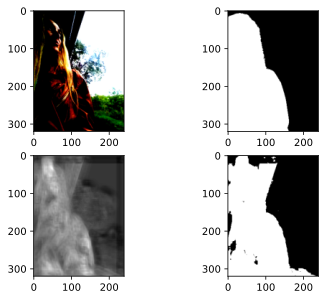

In [50]:
_, ax = plt.subplots(ncols=2, nrows=2)
model.cpu()

img, mask = test_dataset[5]
ax[0, 0].imshow(img.permute(1, 2, 0).numpy())
ax[0, 1].imshow(mask[0, :, :].numpy(), cmap='gray')

ax[1, 0].imshow(model_ld(img[None, :, :, :])[0, 0, :, :].detach().numpy(), cmap='gray')
ax[1, 1].imshow(model_ld(img[None, :, :, :])[0, 0, :, :].detach().numpy() > 0.0, cmap='gray')

(array([[  0.,  11.,  34., ...,   0.,   0.,   0.],
        [  0.,   5.,  38., ...,   0.,   0.,   0.],
        [  0.,   8.,  47., ...,   0.,   0.,   0.],
        ...,
        [ 16., 284.,  17., ...,   0.,   0.,   0.],
        [  0., 275.,  38., ...,   0.,   0.,   0.],
        [  7., 261.,  44., ...,   0.,   0.,   0.]]),
 array([-5.62578201, -4.0547657 , -2.48374963, -0.91273338,  0.65828288,
         2.22929907,  3.80031538,  5.37133169,  6.94234753,  8.51336384,
        10.08438015]),
 <a list of 240 BarContainer objects>)

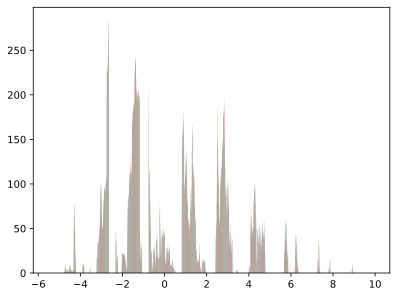

In [48]:
plt.hist(model_ld(img[None, :, :, :])[0, 0, :, :].detach().numpy())

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

Декодировщик для LinkNet

In [48]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.ReLU(),
        )

    def forward(self, down, left):
        # Upsample x2 и свёртка

        x = self.upconv(F.interpolate(down, scale_factor=2))

        # Конкатенация выхода энкодера и предыдущего блока декодера
        x = x + left

        # Две свёртки с ReLu
        # your code here
        x = self.conv_block(x)

        return x

In [49]:
class LinkNetDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, LinkNetDecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [50]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)

        self.decoder = LinkNetDecoder(num_blocks=num_blocks-1, num_filters=64)

        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)

        return x

### Подбор loss function

Скорость обучения будет взята из предыдущего пункта

In [ ]:
torch.cuda.empty_cache()

params = {
    'model_name': 'LinkNet_CE',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'BCE',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g)

model = LinkNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = nn.BCEWithLogitsLoss(reduction='mean').to(device)
val_loss = nn.BCEWithLogitsLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 53742.9543 IoU: 0.32730484685153827
	Test set at batch      0: Avg. loss: 0.7037 IoU: 0.2741568684577942 GradNorm: 0.63337186
	Test set at batch     10: Avg. loss: 0.4493 IoU: 0.713524580001831 GradNorm: 1.27002807
	Test set at batch     20: Avg. loss: 0.2817 IoU: 0.819040060043335 GradNorm: 2.96065888
	Test set at batch     30: Avg. loss: 0.3859 IoU: 0.7366318702697754 GradNorm: 2.31257207
	Test set at batch     40: Avg. loss: 0.2823 IoU: 0.844452977180481 GradNorm: 1.75944931
	Test set at batch     50: Avg. loss: 0.2039 IoU: 0.8874490857124329 GradNorm: 1.09651679
	Test set at batch     60: Avg. loss: 0.3026 IoU: 0.7845239639282227 GradNorm: 1.39383460
	Test set at batch     70: Avg. loss: 0.2263 IoU: 0.8802427649497986 GradNorm: 1.23909514
	Test set at batch     80: Avg. loss: 0.2410 IoU: 0.8603414297103882 GradNorm: 1.13451374
	Test set at batch     90: Avg. loss: 0.2300 IoU: 0.7977551221847534 GradNorm: 1.16845805
	Test set at batch    100: Avg. loss: 0.2150 I

In [ ]:
torch.cuda.empty_cache()

params = {
    'model_name': 'LinkNet_Dice',
    'num_blocks': 4,
    'num_classes': 1,
    'lr':1e-4,
    'gamma': 0.0,
    'loss_function': 'Dice',
    'scheduler': 'ReduceLROnPlateau',
    'n_epochs': 25,
    'seed': 42
}

g = set_global_seed(params['seed'])

writer = SummaryWriter(params['model_name'])

train_data_loader, test_data_loader, samples_data_loader = init_loaders(g)

model = LinkNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

writer.add_hparams(
    params,
    {}
)

writer.add_graph(
    model=model,
    verbose=False,
    input_to_model=next(iter(train_data_loader))[0].to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

train_loss = DiceLoss(reduction='mean').to(device)
val_loss = DiceLoss(reduction='sum').to(device)

IoU_train = IoUScore(0.0, reduction='mean').to(device)
IoU_val = IoUScore(0.0, reduction='sum').to(device)

train_val(
    network=model,
    train_criterion=train_loss,
    train_metric=IoU_train,
    val_criterion=val_loss,
    val_metric=IoU_val,
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    samples_loader=samples_data_loader,
    n_epochs=params['n_epochs'],
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
    metric_dump_threshold=0.8,
)

In [ ]:
for model_idx, gamma in enumerate([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    torch.cuda.empty_cache()

    params = {
        'model_name': f'LinkNet_Mixed_{model_idx+1}',
        'num_blocks': 4,
        'num_classes': 1,
        'lr':1e-4,
        'gamma': gamma,
        'loss_function': 'Mixed: Dice and BCE',
        'scheduler': 'ReduceLROnPlateau',
        'n_epochs': 25,
        'seed': 42
    }

    g = set_global_seed(params['seed'])
    
    writer = SummaryWriter(params['model_name'])

    train_data_loader, test_data_loader, samples_data_loader = init_loaders(g)

    model = LinkNet(num_blocks=params['num_blocks'], num_classes=params['num_classes']).to(device)

    writer.add_hparams(
        params,
        {}
    )

    writer.add_graph(
        model=model,
        verbose=False,
        input_to_model=next(iter(train_data_loader))[0].to(device)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)

    train_loss = MixedLoss(
        crt_1=nn.BCEWithLogitsLoss(reduction='mean'),
        crt_2=DiceLoss(reduction='mean'),
        gamma=params['gamma']
    ).to(device)

    val_loss = MixedLoss(
        crt_1=nn.BCEWithLogitsLoss(reduction='sum'),
        crt_2=DiceLoss(reduction='sum'),
        gamma=params['gamma']
    ).to(device)

    IoU_train = IoUScore(0.0, reduction='mean').to(device)
    IoU_val = IoUScore(0.0, reduction='sum').to(device)

    train_val(
        network=model,
        train_criterion=train_loss,
        train_metric=IoU_train,
        val_criterion=val_loss,
        val_metric=IoU_val,
        optimizer=optimizer,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        samples_loader=samples_data_loader,
        n_epochs=params['n_epochs'],
        writer=writer,
        lr_scheduler=lr_scheduler,
        logging_interval=10,
        best_dump_path=f'./{params["model_name"]}/{params["model_name"]}_best.bin',
        metric_dump_threshold=0.8,
    )

### Аугментация

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```